In [1]:
# importing packages. See https://github.com/BasisResearch/collab-creatures for repo setup
import logging
import os
import time


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import collab2.foraging.toolkit as ft
from collab2.foraging.toolkit import (
    dataObject,
    plot_predictor,
    rescale_to_grid,
    subset_frames_evenly_spaced,
)
from collab2.utils import find_repo_root

from collab2.foraging.toolkit.waic import compute_waic

logging.basicConfig(format="%(message)s", level=logging.INFO)

root = find_repo_root()

# users can ignore smoke_test -- it's for automatic testing on GitHub,
# to make sure the notebook runs on future updates to the repository
smoke_test = "CI" in os.environ
smoke_test = True
frames = 150 if smoke_test else 300
frames_sps = 150 if smoke_test else 2300
sampling_rate = 0.001 if smoke_test else 0.01

notebook_starts = time.time()

In [2]:
ducks_raw = pd.read_csv(
    os.path.join(
        root,
        "data/foraging/central_park_birds_cleaned_2022/20221215122046189_-5_25_bone.avi.hand_checked_cleaned_df.csv",
    )
)
sparrows_raw = pd.read_csv(
    os.path.join(
        root,
        "data/foraging/central_park_birds_cleaned_2022/20221229124843603_n5_25_bone.avi.hand_checked_cleaned_df.csv",
    )
)

ducks_raw = ducks_raw.rename(columns={"bird": "forager"})
sparrows_raw = sparrows_raw.rename(columns={"bird": "forager"})

ducks_sub = ft.subset_frames_evenly_spaced(ducks_raw, frames)
ducks_sub = ft.rescale_to_grid(ducks_sub, 90)
ducks_object = dataObject(foragersDF = ducks_sub)

sps_sub = ft.subset_frames_evenly_spaced(sparrows_raw, frames_sps)
sps_sub = ft.rescale_to_grid(sps_sub, 90)
sps_object = dataObject(foragersDF = sps_sub)   


original_frames: 1451
original_shape: (8867, 4)
resulting_frames: 150
resulting_shape: (933, 4)
original_frames: 11550
original_shape: (22821, 4)
resulting_frames: 141
resulting_shape: (323, 4)


/home/rafal/s78projects/collab-creatures/collab2/foraging/toolkit/utils.py:62: UserWarning: 
                    Missing frames encountered for forager 0, adding NaN fillers.
                    The default behavior of predictor/score generating functions is
                    to ignore foragers with missing positional data. To modify, see documentation of
                    `derive_predictors_and_scores` and `generate_local_windows`
                    
  warnings.warn(
/home/rafal/s78projects/collab-creatures/collab2/foraging/toolkit/utils.py:62: UserWarning: 
                    Missing frames encountered for forager 1, adding NaN fillers.
                    The default behavior of predictor/score generating functions is
                    to ignore foragers with missing positional data. To modify, see documentation of
                    `derive_predictors_and_scores` and `generate_local_windows`
                    
  warnings.warn(
/home/rafal/s78projects/collab-creatures/col

In [3]:
datalist = ducks_object.foragers
source = ducks_sub

# we do this as central park birds data contains many birds flying away

def test_data_object_correctness(datalist, source):
    for forager in source['forager'].unique():
        for time in source['time'].unique():

            data = datalist[forager][datalist[forager]["time"] == time]
            sourced = source[(source["forager"] == forager) & (source["time"] == time)]
            
            if len(sourced) > 0:
                assert len(sourced) == 1
                assert sourced["x"].values == data["x"].values
                assert sourced["y"].values == data["y"].values

            if len(sourced) == 0:
                assert data["x"].isna().sum() == len(data)
                
    print("Data tests passed")

test_data_object_correctness(ducks_object.foragers, ducks_sub)
test_data_object_correctness(sps_object.foragers, sps_sub)


Data tests passed
Data tests passed


In [4]:
# let's get a feel for the distance distributions
# might take a while to run
duck_distances = ft.foragers_to_forager_distances(ducks_object)
sps_distances = ft.foragers_to_forager_distances(sps_object)


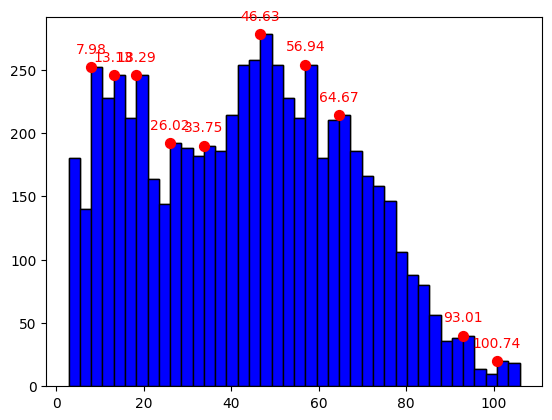

In [5]:
ft.distances_and_peaks(duck_distances)


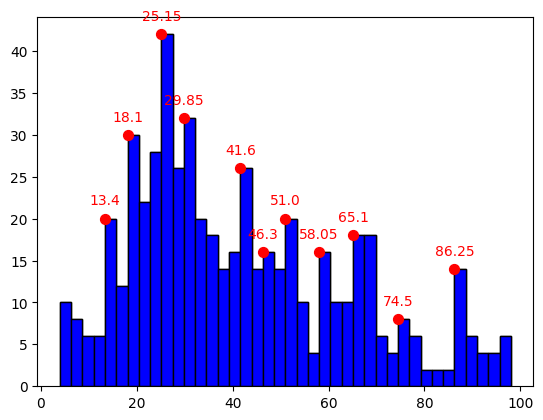

In [6]:
ft.distances_and_peaks(sps_distances)

In [13]:
# for instance, it seems that as a proximity parameter setting
# values around 25 should work well for sparrows, less so ducks
# values around 55 should work well for ducks, not terribly for sparrows
# values around 80 should not work very well for either
# we'll keep these in mind as sanity checks

local_windows_kwargs = {
    "window_size": 20,  # in paper: locust sight goes beyond the grid
    "sampling_fraction": 1,
    "skip_incomplete_frames": False,
}


# predictor_kwargs = {
#     "access": {
#         "decay_factor": 0.2,
#     },
# }

# Emily wanted to try out all these values
# Rafal thinks these are too many options and prefers staying with 20, 50, and 80
# reason: histograms get cluttered and clarity is lost
proximity_optimal_candidates = [25, 55, 80] #[10, 20, 30, 40, 50, 60, 70, 80] 

predictor_kwargs = {}
for opt in proximity_optimal_candidates:
    predictor_kwargs[f"proximity_{opt}"] =  {
        "interaction_length": 90 / 9,
        "interaction_constraint": None,
        "interaction_constraint_params": {},
        "repulsion_radius": 5,
        "optimal_distance": opt,
        "proximity_decay": 1.2,
    }


score_kwargs = {
    "nextStep_linear": {"nonlinearity_exponent": 1},
    "nextStep_sublinear": {"nonlinearity_exponent": 0.5},
}

ducks_derivedDF = ft.derive_predictors_and_scores(
    ducks_object,
    local_windows_kwargs,
    predictor_kwargs=predictor_kwargs,
    score_kwargs=score_kwargs,
    dropna=True,
    add_scaled_values=True,
)

sps_derivedDF = ft.derive_predictors_and_scores(
    sps_object,
    local_windows_kwargs,
    predictor_kwargs=predictor_kwargs,
    score_kwargs=score_kwargs,
    dropna=True,
    add_scaled_values=True,
)
display(ducks_derivedDF.head())

2024-10-08 11:14:16,658 - proximity_25 completed in 2.59 seconds.
2024-10-08 11:14:19,274 - proximity_55 completed in 2.62 seconds.
2024-10-08 11:14:22,352 - proximity_80 completed in 3.08 seconds.
2024-10-08 11:14:23,337 - nextStep_linear completed in 0.98 seconds.
2024-10-08 11:14:24,330 - nextStep_sublinear completed in 0.99 seconds.
/home/rafal/s78projects/collab-creatures/collab2/foraging/toolkit/derive.py:56: UserWarning:


                      Dropped 20922/944778 frames from `derivedDF` due to NaN values.
                      Missing values can arise when computations depend on next/previous step positions
                      that are unavailable. See documentation of the corresponding predictor/score generating
                      functions for more information.
                      

2024-10-08 11:14:27,792 - proximity_25 completed in 0.68 seconds.
2024-10-08 11:14:28,459 - proximity_55 completed in 0.67 seconds.
2024-10-08 11:14:29,121 - proximity_80 completed in 0.66

x   y  distance_to_forager  time  forager  proximity_25  proximity_55  \
0  52  18            20.000000    56        0           0.0           0.0   
1  53  12            19.924859    56        0           0.0           0.0   
2  53  13            19.646883    56        0           0.0           0.0   
3  53  14            19.416488    56        0           0.0           0.0   
4  53  15            19.235384    56        0           0.0           0.0   

   proximity_80  distance_to_next_step  nextStep_linear  nextStep_sublinear  \
0           0.0              20.000000         0.000000            0.000000   
1           0.0              19.924859         0.003757            0.001880   
2           0.0              19.646883         0.017656            0.008867   
3           0.0              19.416488         0.029176            0.014696   
4           0.0              19.235384         0.038231            0.019302   

   proximity_25_scaled  proximity_55_scaled  proximity_80_scaled  \
0                  0.5                  0.5                  0.5   
1                  0.5                  0.5                  0.5   
2                  0.5                  0.5                  0.5   
3                  0.5                  0.5                  0.5   
4                  0.5                  0.5                  0.5   

   nextStep_linear_scaled  nextStep_sublinear_scaled  
0                0.000000                   0.000000  
1                0.003757                   0.001880  
2                0.017656                   0.008867  
3                0.029176                   0.014696  
4                0.038231                   0.019302

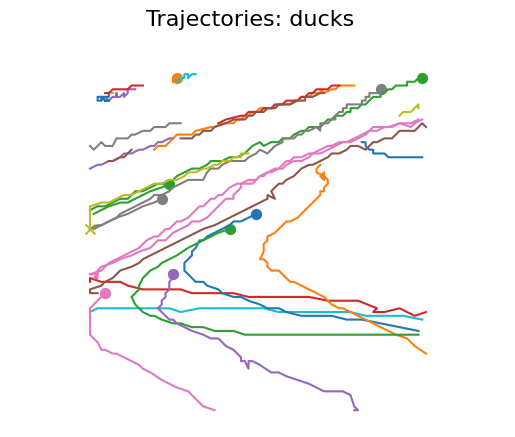

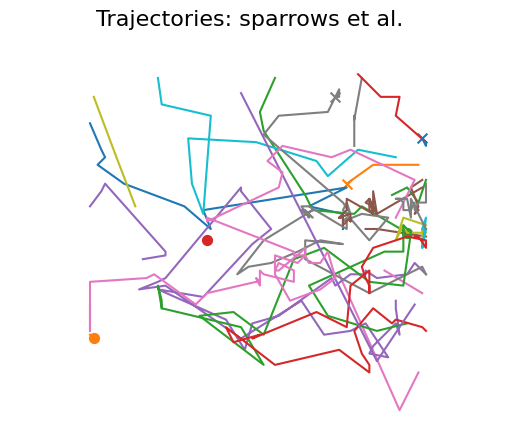

In [14]:
fig = ft.plot_trajectories(ducks_object.foragersDF, "ducks", legend = False) 
# too many birds to show legend
fig.show()
path = os.path.join(root, "docs/figures/fig_bird_trajectories_ducks.png")
if not os.path.exists(path):
    plt.savefig(path, dpi=300)

plt = ft.plot_trajectories(sps_object.foragersDF, "sparrows et al.", legend = False)
plt.show()
path = os.path.join(root, "docs/figures/fig_bird_trajectories_sps.png")
if not os.path.exists(path):
    plt.savefig(path, dpi=300)

In [15]:
fig = ft.plot_distances(sps_distances, "sparrows et al.")
fig.show()
path = os.path.join(root, "docs/figures/fig_distance_distribution_sps.png")
if not os.path.exists(path):
    fig.write_image(path, scale=2)

fig = ft.plot_distances(duck_distances, "ducks")
fig.show()
path = os.path.join(root, "docs/figures/fig_distance_distribution_ducks.png")
if not os.path.exists(path):
    fig.write_image(path, scale=2)

notebook_ends = time.time()

print(
    f"notebook took {notebook_ends - notebook_starts} seconds, {(notebook_ends - notebook_starts)/60} minutes to run"
)

notebook took 351.8069396018982 seconds, 5.86344899336497 minutes to run


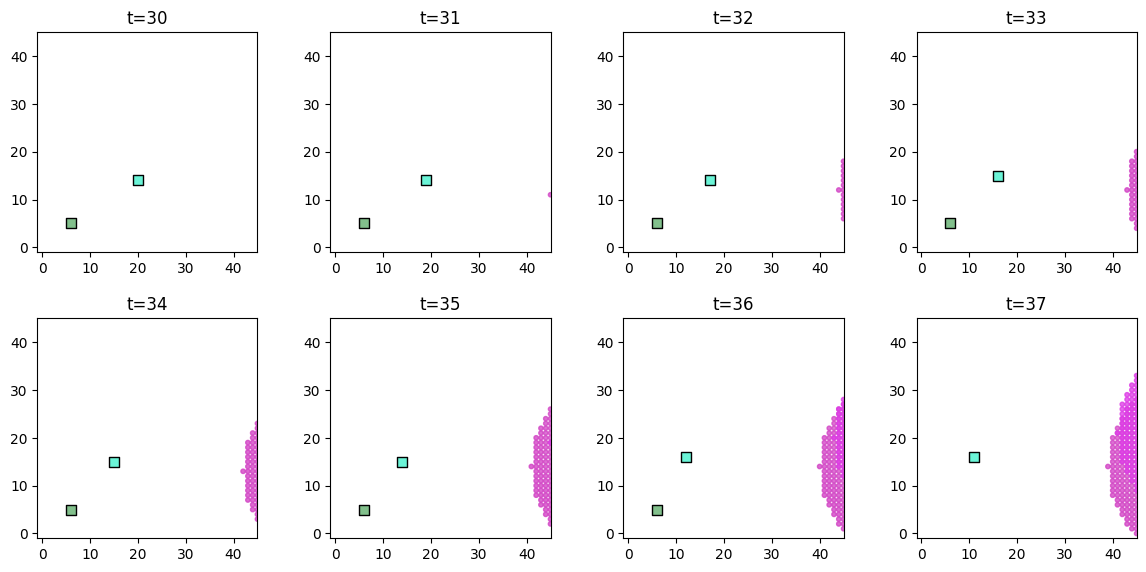

In [16]:
plot_predictor(
    ducks_object.foragers,
    ducks_object.derived_quantities["proximity_25"],
    predictor_name="proximity_25",
    time=range(30,38),
    grid_size=45,
    size_multiplier=10,
    random_state=99,
    forager_position_indices=list(range(20)),
    forager_predictor_indices=list(range(20)),
)

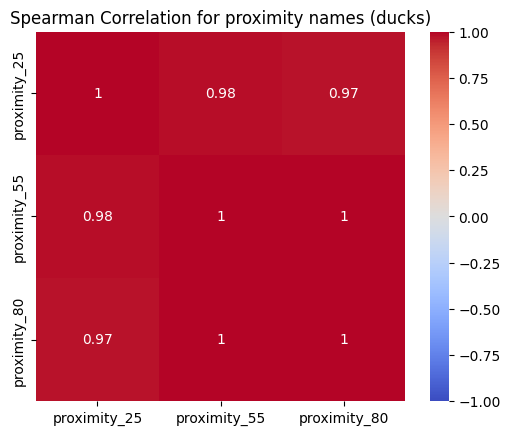

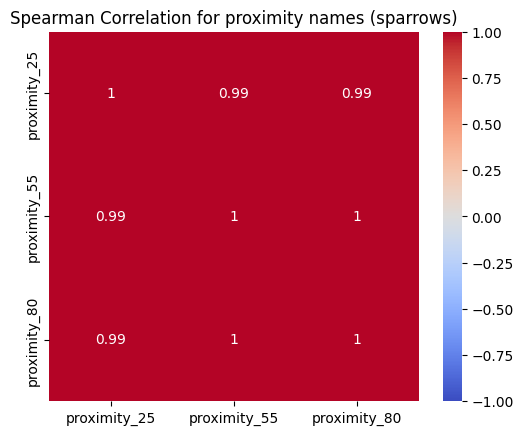

In [17]:
proximity_names = [f"proximity_{opt}" for opt in proximity_optimal_candidates]

derivedDFs = {"ducks": ducks_derivedDF, "sparrows": sps_derivedDF}
#plot spearman correlation for  proximity names:
for key in derivedDFs.keys():
    proximity_data = derivedDFs[key][proximity_names]
    spearman_corr = proximity_data.corr(method='spearman')
    sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
    plt.title(f"Spearman Correlation for proximity names ({key})")
    plt.show()

# there are strong correlations between these predictors, 
# instead of using them in a single model
# we will train separate models and look at their WAIC scores

2024-10-08 11:15:12,827 - Starting SVI inference with 1000 iterations.


Sample size: 46193
[iteration 0001] loss: 79569.3750
[iteration 0050] loss: 35241.6602
[iteration 0100] loss: 32210.9297
[iteration 0150] loss: 32511.4355
[iteration 0200] loss: 31689.8125
[iteration 0250] loss: 31753.5234
[iteration 0300] loss: 31596.7832
[iteration 0350] loss: 32340.7988
[iteration 0400] loss: 31732.6016
[iteration 0450] loss: 31715.6738
[iteration 0500] loss: 31678.8730
[iteration 0550] loss: 31596.2734
[iteration 0600] loss: 31587.4824
[iteration 0650] loss: 31603.0938
[iteration 0700] loss: 31524.6738
[iteration 0750] loss: 31538.1680
[iteration 0800] loss: 31638.2129
[iteration 0850] loss: 31550.5586
[iteration 0900] loss: 31550.4883
[iteration 0950] loss: 31563.0859
[iteration 1000] loss: 31819.3828


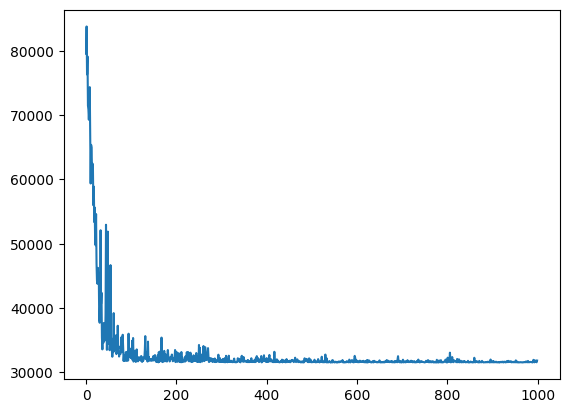

2024-10-08 11:15:17,568 - SVI inference completed in 4.74 seconds.


dict_keys(['bias_continuous_nextStep_sublinear', 'weight_continuous_proximity_25_scaled_nextStep_sublinear', 'bias_continuous_nextStep_sublinear_sigma', 'weight_continuous_proximity_25_scaled_nextStep_sublinear_sigma', 'proximity_25_scaled', 'nextStep_sublinear'])
['weight_continuous_proximity_25_scaled_nextStep_sublinear']
Coefficient marginals:
Site: weight_continuous_proximity_25_scaled_nextStep_sublinear
       mean       std        5%       25%       50%       75%      95%
0 -0.250749  0.012948 -0.272111 -0.259827 -0.250727 -0.242315 -0.22898 



2024-10-08 11:15:18,424 - Starting SVI inference with 1000 iterations.


Sample size: 46193
[iteration 0001] loss: 80805.6094
[iteration 0050] loss: 35720.4414
[iteration 0100] loss: 29598.6934
[iteration 0150] loss: 31130.3379
[iteration 0200] loss: 29118.9629
[iteration 0250] loss: 29302.6875
[iteration 0300] loss: 29043.7305
[iteration 0350] loss: 28939.5645
[iteration 0400] loss: 28872.1309
[iteration 0450] loss: 28888.6777
[iteration 0500] loss: 28786.7012
[iteration 0550] loss: 28961.3867
[iteration 0600] loss: 28702.1094
[iteration 0650] loss: 28879.8008
[iteration 0700] loss: 28698.3672
[iteration 0750] loss: 29095.8672
[iteration 0800] loss: 28769.3184
[iteration 0850] loss: 28959.9512
[iteration 0900] loss: 28852.6172
[iteration 0950] loss: 28716.7402
[iteration 1000] loss: 29250.1035


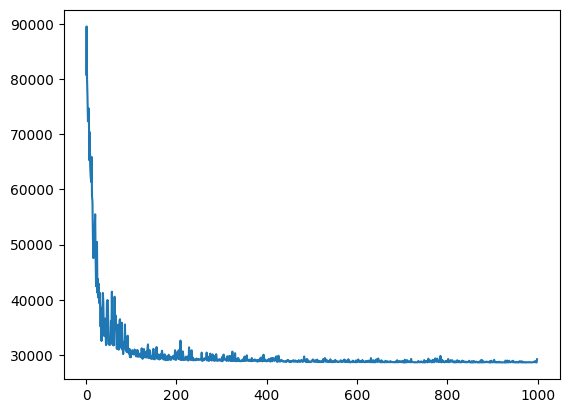

2024-10-08 11:15:26,890 - SVI inference completed in 8.46 seconds.


dict_keys(['bias_continuous_nextStep_sublinear', 'weight_continuous_proximity_55_scaled_nextStep_sublinear', 'bias_continuous_nextStep_sublinear_sigma', 'weight_continuous_proximity_55_scaled_nextStep_sublinear_sigma', 'proximity_55_scaled', 'nextStep_sublinear'])
['weight_continuous_proximity_55_scaled_nextStep_sublinear']
Coefficient marginals:
Site: weight_continuous_proximity_55_scaled_nextStep_sublinear
       mean       std        5%       25%       50%       75%      95%
0 -0.417905  0.012846 -0.439346 -0.426412 -0.418234 -0.410011 -0.39554 



2024-10-08 11:15:27,680 - Starting SVI inference with 1000 iterations.


Sample size: 46193
[iteration 0001] loss: 86609.2578
[iteration 0050] loss: 31368.9590
[iteration 0100] loss: 31988.6387
[iteration 0150] loss: 29749.2324
[iteration 0200] loss: 29146.0293
[iteration 0250] loss: 29785.3340
[iteration 0300] loss: 29161.5664
[iteration 0350] loss: 29641.4844
[iteration 0400] loss: 29063.8652
[iteration 0450] loss: 29093.0410
[iteration 0500] loss: 29022.4785
[iteration 0550] loss: 29018.7363
[iteration 0600] loss: 29029.2598
[iteration 0650] loss: 28971.8984
[iteration 0700] loss: 29204.3027
[iteration 0750] loss: 29071.7383
[iteration 0800] loss: 29073.0098
[iteration 0850] loss: 28939.2559
[iteration 0900] loss: 28942.2754
[iteration 0950] loss: 28928.4395
[iteration 1000] loss: 29180.4590


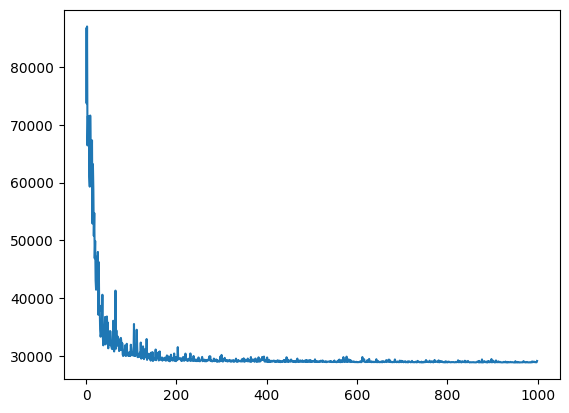

2024-10-08 11:15:36,318 - SVI inference completed in 8.64 seconds.


dict_keys(['bias_continuous_nextStep_sublinear', 'weight_continuous_proximity_80_scaled_nextStep_sublinear', 'bias_continuous_nextStep_sublinear_sigma', 'weight_continuous_proximity_80_scaled_nextStep_sublinear_sigma', 'proximity_80_scaled', 'nextStep_sublinear'])
['weight_continuous_proximity_80_scaled_nextStep_sublinear']
Coefficient marginals:
Site: weight_continuous_proximity_80_scaled_nextStep_sublinear
      mean       std        5%       25%       50%       75%       95%
0 -0.45974  0.014136 -0.481233 -0.468719 -0.459311 -0.450651 -0.436878 



2024-10-08 11:15:37,134 - Starting SVI inference with 1000 iterations.


Sample size: 15814
[iteration 0001] loss: 25294.0527
[iteration 0050] loss: 11563.1445
[iteration 0100] loss: 11383.8652
[iteration 0150] loss: 11217.8105
[iteration 0200] loss: 11318.1426
[iteration 0250] loss: 11278.0127
[iteration 0300] loss: 11193.4697
[iteration 0350] loss: 11323.6670
[iteration 0400] loss: 11193.4346
[iteration 0450] loss: 11184.3018
[iteration 0500] loss: 11278.5225
[iteration 0550] loss: 11278.4404
[iteration 0600] loss: 11236.4043
[iteration 0650] loss: 11188.9639
[iteration 0700] loss: 11309.6426
[iteration 0750] loss: 11277.4346
[iteration 0800] loss: 11287.5391
[iteration 0850] loss: 11198.5527
[iteration 0900] loss: 11195.7520
[iteration 0950] loss: 11214.2061
[iteration 1000] loss: 11191.6348


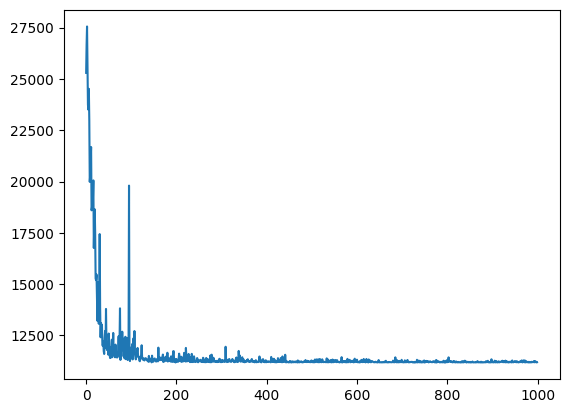

2024-10-08 11:15:41,690 - SVI inference completed in 4.56 seconds.
2024-10-08 11:15:41,966 - Starting SVI inference with 1000 iterations.


dict_keys(['bias_continuous_nextStep_sublinear', 'weight_continuous_proximity_25_scaled_nextStep_sublinear', 'bias_continuous_nextStep_sublinear_sigma', 'weight_continuous_proximity_25_scaled_nextStep_sublinear_sigma', 'proximity_25_scaled', 'nextStep_sublinear'])
['weight_continuous_proximity_25_scaled_nextStep_sublinear']
Coefficient marginals:
Site: weight_continuous_proximity_25_scaled_nextStep_sublinear
       mean       std        5%       25%       50%       75%       95%
0 -0.157068  0.021769 -0.192274 -0.172491 -0.157144 -0.141746 -0.121803 

Sample size: 15814
[iteration 0001] loss: 28271.6543
[iteration 0050] loss: 11812.0703
[iteration 0100] loss: 12051.3438
[iteration 0150] loss: 11949.3633
[iteration 0200] loss: 11440.2217
[iteration 0250] loss: 11226.1826
[iteration 0300] loss: 11254.0205
[iteration 0350] loss: 11172.0420
[iteration 0400] loss: 11316.7734
[iteration 0450] loss: 11146.0439
[iteration 0500] loss: 11292.5645
[iteration 0550] loss: 11125.5254
[iteration 0600

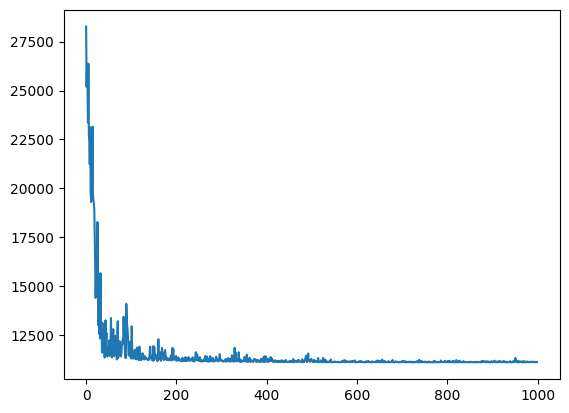

2024-10-08 11:15:45,467 - SVI inference completed in 3.50 seconds.


dict_keys(['bias_continuous_nextStep_sublinear', 'weight_continuous_proximity_55_scaled_nextStep_sublinear', 'bias_continuous_nextStep_sublinear_sigma', 'weight_continuous_proximity_55_scaled_nextStep_sublinear_sigma', 'proximity_55_scaled', 'nextStep_sublinear'])
['weight_continuous_proximity_55_scaled_nextStep_sublinear']
Coefficient marginals:
Site: weight_continuous_proximity_55_scaled_nextStep_sublinear
       mean       std        5%       25%       50%       75%       95%
0 -0.320558  0.019821 -0.352933 -0.333632 -0.321021 -0.307638 -0.288555 



2024-10-08 11:15:45,764 - Starting SVI inference with 1000 iterations.


Sample size: 15814
[iteration 0001] loss: 27790.3633
[iteration 0050] loss: 14137.2539
[iteration 0100] loss: 11755.1602
[iteration 0150] loss: 11972.6074
[iteration 0200] loss: 11535.2881
[iteration 0250] loss: 11406.8037
[iteration 0300] loss: 11465.6406
[iteration 0350] loss: 11530.3857
[iteration 0400] loss: 11835.0361
[iteration 0450] loss: 11384.5176
[iteration 0500] loss: 11460.1201
[iteration 0550] loss: 11371.6934
[iteration 0600] loss: 11352.9824
[iteration 0650] loss: 11396.3076
[iteration 0700] loss: 11339.4756
[iteration 0750] loss: 11345.9893
[iteration 0800] loss: 11342.2568
[iteration 0850] loss: 11348.6846
[iteration 0900] loss: 11349.7207
[iteration 0950] loss: 11349.1973
[iteration 1000] loss: 11372.4336


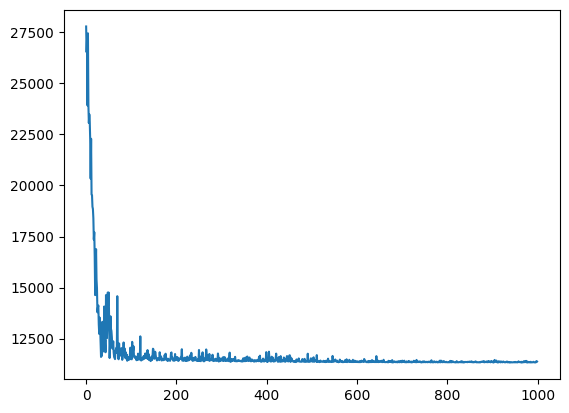

2024-10-08 11:15:53,298 - SVI inference completed in 7.53 seconds.


dict_keys(['bias_continuous_nextStep_sublinear', 'weight_continuous_proximity_80_scaled_nextStep_sublinear', 'bias_continuous_nextStep_sublinear_sigma', 'weight_continuous_proximity_80_scaled_nextStep_sublinear_sigma', 'proximity_80_scaled', 'nextStep_sublinear'])
['weight_continuous_proximity_80_scaled_nextStep_sublinear']
Coefficient marginals:
Site: weight_continuous_proximity_80_scaled_nextStep_sublinear
       mean       std        5%       25%       50%       75%       95%
0 -0.332419  0.021409 -0.366853 -0.346813 -0.332787 -0.317643 -0.296584 

{'ducks': {25: tensor(-40675.3047, grad_fn=<MulBackward0>), 55: tensor(-42976.7461, grad_fn=<MulBackward0>), 80: tensor(-41190.3398, grad_fn=<MulBackward0>)}, 'sparrows': {25: tensor(-10974.6475, grad_fn=<MulBackward0>), 55: tensor(-10938.1543, grad_fn=<MulBackward0>), 80: tensor(-10896.1768, grad_fn=<MulBackward0>)}}


In [18]:
waic_scores = {}
results = {}

sps_object.derivedDF = sps_derivedDF
ducks_object.derivedDF = ducks_derivedDF

data_objects = {"ducks": ducks_object, "sparrows": sps_object}

for key in data_objects:
    results[key] = {}
    waic_scores[key] = {}

    for proximity_candidate in proximity_optimal_candidates:

        predictors = [f"proximity_{proximity_candidate}_scaled",]
        outcome_vars = ["nextStep_sublinear"]

        predictor_dict, outcome_dict = ft.prep_data_for_inference(
            data_objects[key],
            predictors,
            outcome_vars,
            subsample_rate=0.05,
        )

        model = ft.HeteroskedasticLinear(
            predictor_dict, outcome_dict
            )

        outcome = ft.get_samples(
        model=model,
        predictors=predictor_dict,
        outcome=outcome_dict,
        num_svi_iters=1000,
        num_samples=1000,
        )

        results[key][proximity_candidate] = outcome

        waic_scores[key][proximity_candidate] = compute_waic(
        model=model,
        guide=outcome['guide'],
        num_particles=1000,
        sites=[outcome_vars[0]],
        max_plate_nesting=9,
        predictors = predictor_dict,
        outcome = outcome_dict,
        )['waic']


print(waic_scores)